<a href="https://colab.research.google.com/github/Srija616/pyTorchTutorial/blob/main/03_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn # nn contains the building blocks for neural networks

print (torch.__version__)

1.13.1+cu116


Classification - Neural Network classification

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Make classification data
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000
# Create circles
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

# Make DataFrame of circcle
circles = pd.DataFrame({"X1": X[:, 0], "X2":X[:, 1], "label": y})

In [5]:
circles[:10]

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


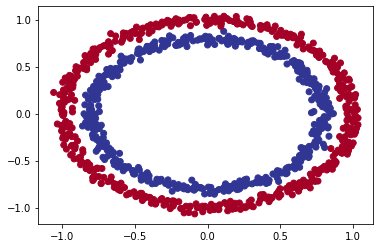

In [4]:
# Visualize 
plt.scatter(x=X[:,0], y=X[:,1], c= y, cmap=plt.cm.RdYlBu);

Check input and output shapes, 
turn numpy data to tensors,
Split data into train-test split


In [6]:
y = y.reshape((1000, 1))
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [7]:
# Train-test split
split = int(0.8* len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

Build the model
1. Setup device agnostic code
2. construct a model - subclass nn.module
3. Define a loss function and optimizer
4. Create a training and test loop

In [9]:
class NeuralClassificationModel(nn.Module): 
    '''
    nn.Module has almost everything that PyTorch model needs - base class for all neural models. 
    '''
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features = 5) #upscales to five features
        self.layer_2 = nn.Linear(in_features=5, out_features = 1) #output layers
    
    def forward(self, x) -> torch.Tensor: # x is input
        return self.layer_2(self.layer_1(x))

model_0 = NeuralClassificationModel().to(device)
# or
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features = 5),
#     nn.Linear(in_features=5, out_features = 1)
# )
loss_func = nn.BCEWithLogitsLoss() # sigmoid activation function built in. i.e. I need to pass the output probabilities
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01, momentum=0.9)


In [10]:
model_0.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5438, -0.2989],
                      [-0.3509,  0.4658],
                      [ 0.3451,  0.2321],
                      [ 0.0210, -0.5992],
                      [-0.0761,  0.0328]])),
             ('layer_1.bias',
              tensor([-0.4365,  0.0474,  0.1389,  0.1413,  0.6207])),
             ('layer_2.weight',
              tensor([[ 0.4053, -0.3320,  0.3556,  0.3968,  0.2782]])),
             ('layer_2.bias', tensor([0.0262]))])

In [11]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print (f"Length of preds: {len(untrained_preds)}, Shape = {untrained_preds.shape}")


Length of preds: 200, Shape = torch.Size([200, 1])


# Calculate accuracy
Accuracy = TP/TP+TN  - the number of actual positives in the total samples which model says as positive

In [19]:
# def accuracy_func(predictions, y_train):
#     correct = torch.eq(predictions, y_train)
#     acc = correct/len(predictions)
#     return acc

def accuracy_func(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [12]:
# move variables to the device in use (cuda/cpu)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [23]:
epochs = 100
for epoch in range(epochs):
    model_0.train()
    y_preds = model_0(X_train)
    y_preds = torch.round(torch.sigmoid(y_preds))
    loss = loss_func(y_train, y_preds)
    accuracy__ = accuracy_func(y_preds, y_train)
    optimizer.zero_grad()
    # Perform backprop on the loss wrt the params of the model
    loss.backward()

    # Perform gradient descent
    optimizer.step()
    model_0.eval()
    with torch.inference_mode(): # faster than no_grad - old pytorch code
        test_logits = model_0.forward(X_test)
        loss_test = loss_func(test_logits, y_test)
        if (epoch%10 == 0):
            print (f"Epoch:{epoch} | Accuracy: {accuracy__}")
        


Epoch:0 | Accuracy: 50.74999999999999
Epoch:10 | Accuracy: 50.74999999999999
Epoch:20 | Accuracy: 50.74999999999999
Epoch:30 | Accuracy: 50.74999999999999
Epoch:40 | Accuracy: 50.74999999999999
Epoch:50 | Accuracy: 50.74999999999999
Epoch:60 | Accuracy: 50.74999999999999
Epoch:70 | Accuracy: 50.74999999999999
Epoch:80 | Accuracy: 50.74999999999999
Epoch:90 | Accuracy: 50.74999999999999


In [21]:
class CircleModel(nn.Module): 
    '''
    nn.Module has almost everything that PyTorch model needs - base class for all neural models. 
    '''
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features = 10) #upscales to five features
        self.layer_2 = nn.Linear(in_features=10, out_features = 10) #output layers
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        
    def forward(self, x) -> torch.Tensor: # x is input
        return self.layer_3(self.layer_2(self.layer_1(x)))


In [24]:
circle_model = CircleModel()

In [ ]:
for epoch in range(1000):
    circle_model.train()
    y_pred = circle_model.forward(X_train)
    loss = loss_func(y_pred, y_train)
    if (epoch%100 == 0):
        print (f"Epoch:{epoch} | Test: {loss}")
    optimizer.zero_grad() # restarts loop, no residual gradients from previous loop
    loss.backward()

    optimizer.step()
    circle_model.eval()
    with torch.inference_mode(): # faster than no_grad - old pytorch code
        test_logits = circle_model.forward(X_test)
        loss = loss_func(test_logits, y_test)
        if (epoch%10 == 0):
            print (f"Epoch:{epoch} | Test: {loss}")
        
    

Introducing Non-Linearity

In [26]:
class CircleModel_v2(nn.Module): 
    '''
    nn.Module has almost everything that PyTorch model needs - base class for all neural models. 
    '''
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features = 10) #upscales to five features
        self.layer_2 = nn.Linear(in_features=10, out_features = 10) #output layers
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU() #ReLU is a non-linear activation function

        
    def forward(self, x) -> torch.Tensor: # x is input
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [27]:
circle_model_2 = CircleModel_v2()
loss_func = nn.BCEWithLogitsLoss() # sigmoid activation function built in. i.e. I need to pass the output probabilities
optimizer = torch.optim.SGD(circle_model_2.parameters(), lr=0.01, momentum=0.9)


In [ ]:
for epoch in range(100):
    circle_model_2.train()
    y_pred = circle_model_2.forward(X_train)
    loss = loss_func(y_pred, y_train)
    if (epoch%10 == 0):
        print (f"Epoch:{epoch} | Test: {loss}")
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    circle_model_2.eval()
    with torch.inference_mode(): # faster than no_grad - old pytorch code
        test_logits = circle_model_2.forward(X_test)
        loss = loss_func(test_logits, y_test)
        if (epoch%10 == 0):
            print (f"Epoch:{epoch} | Test: {loss}")
        
    

Mult-class classificcation problem

In [29]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42    

# Create multi-class data

X_blob, y_blob = make_blobs(n_samples = 1000, n_features = NUM_FEATURES, centers = NUM_CLASSES, cluster_std = 2, random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

In [30]:
X_blob_test.shape

torch.Size([200, 2])

In [31]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

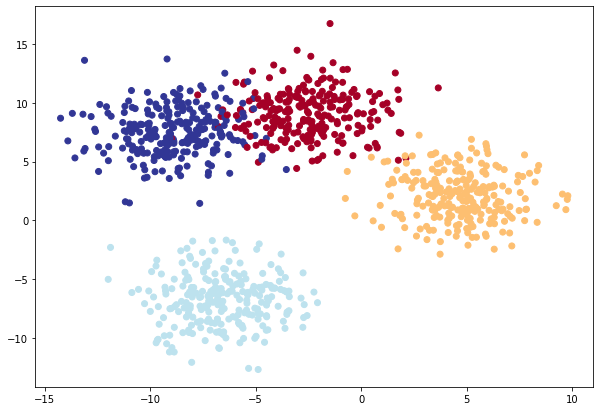

In [32]:
plt.figure(figsize =(10,7))
plt.scatter (X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

In [33]:
# Multi-class classification model
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__() # this is for inheritance 
        '''
        Args: 
            input_features(int): Number of input features to the model
            output_features(int): Number of output features (number of output classes)
            hidden_units(int): Number of hidden units between layers, default 8

        Returns:

        Examples:
        '''
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units , out_features = output_features)
        )
    def forward(self,x):
        return self.linear_stack(x)
    

model_multiclass = BlobModel(input_features = 2, output_features = 4, hidden_units = 8)



In [34]:
loss_func = nn.CrossEntropyLoss() # sigmoid activation function built in. i.e. I need to pass the output probabilities
optimizer = torch.optim.SGD(model_multiclass.parameters(), lr=0.01, momentum=0.9)


In [35]:
next(model_multiclass.parameters()).device

device(type='cpu')

In [36]:
y_pred = model_multiclass.forward(X_blob_train)
prediction_probabilities = torch.softmax(y_pred, dim =1)
predicted_label = torch.argmax(prediction_probabilities)


In [37]:
y_blob_train.dtype

torch.int64

In [38]:
print (torch.sum(prediction_probabilities[0]))
print (torch.max(prediction_probabilities[0]))
print (torch.argmax(prediction_probabilities[0]))

tensor(1., grad_fn=<SumBackward0>)
tensor(0.3218, grad_fn=<MaxBackward1>)
tensor(3)


In [42]:
 # convert model's output which are logits to prediction probabilities to prediction labels
for epoch in range(100):
    model_multiclass.train()
    y_pred = model_multiclass.forward(X_blob_train)
    prediction_probabilities = torch.softmax(y_pred, dim = 1)
    predicted_label = torch.argmax(prediction_probabilities, dim = 1)
    loss = loss_func(y_pred, y_blob_train)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    model_multiclass.eval()
    with torch.inference_mode(): # faster than no_grad - old pytorch code
        test_logits = model_multiclass.forward(X_blob_test)
        probs = torch.softmax(test_logits, dim =1).argmax(dim=1)
        loss = loss_func(test_logits, y_blob_test)
        if (epoch%10 == 0):
            print (f"Epoch:{epoch} | Test: {loss}")
        

Epoch:0 | Test: 0.07993889600038528
Epoch:10 | Test: 0.0797443762421608
Epoch:20 | Test: 0.07956082373857498
Epoch:30 | Test: 0.07939794659614563
Epoch:40 | Test: 0.07923108339309692
Epoch:50 | Test: 0.07905872911214828
Epoch:60 | Test: 0.0788993239402771
Epoch:70 | Test: 0.07874415069818497
Epoch:80 | Test: 0.07860597968101501
Epoch:90 | Test: 0.07846350967884064


In [43]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


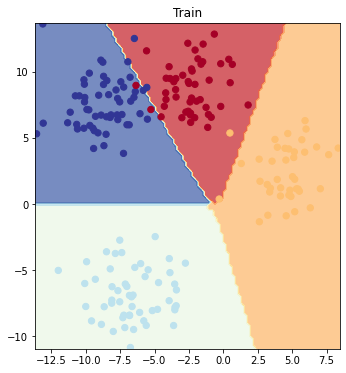

In [44]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_multiclass, X_blob_test, y_blob_test)

9. A few more classification metrics...

a. Accuracy - out of 100 samples, how many our model gets right. Not the best for imbalanced classes.

b. For imbalanced datasets, precision and recall. Beyond accuracy will kohesron

c. Precision recall trade off 

d. F1 score - combines precision and recall

e. Confusion Matrix - what is it?


In [46]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 15.5 MB/s eta 0:00:00


In [47]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task = "multiclass", num_classes = 4)
torchmetric_accuracy(predicted_label,  y_blob_train)

tensor(0.9638)